In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Download the dataset and define column names
data = pd.read_csv('adult.data', header=None)

# Assign column names
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
                'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
                'income']

data.columns = column_names


# Data Preprocessing
data.replace(' ?', np.nan, inplace=True)  # Replace missing values with NaN
data.dropna(inplace=True)  # Drop rows with missing values

# Convert categorical features to numerical using one-hot encoding
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex',
                        'native_country']


# Perform label encoding on categorical features
le = LabelEncoder()
for feature in categorical_features:
  data[feature] = le.fit_transform(data[feature])



In [31]:
data.shape

(30160, 15)

In [34]:
# Perform one-hot encoding to convert categorical features to numerical representations
X = data.drop(['income'], axis = 1)
y = data['income']
from imblearn.combine import SMOTETomek
smk = SMOTETomek()
X_res,y_res =smk.fit_resample(X,y)
X_res.shape,y_res.shape

((40882, 14), (40882,))

(40882, 14)
 <=50K    20441
 >50K     20441
Name: income, dtype: int64


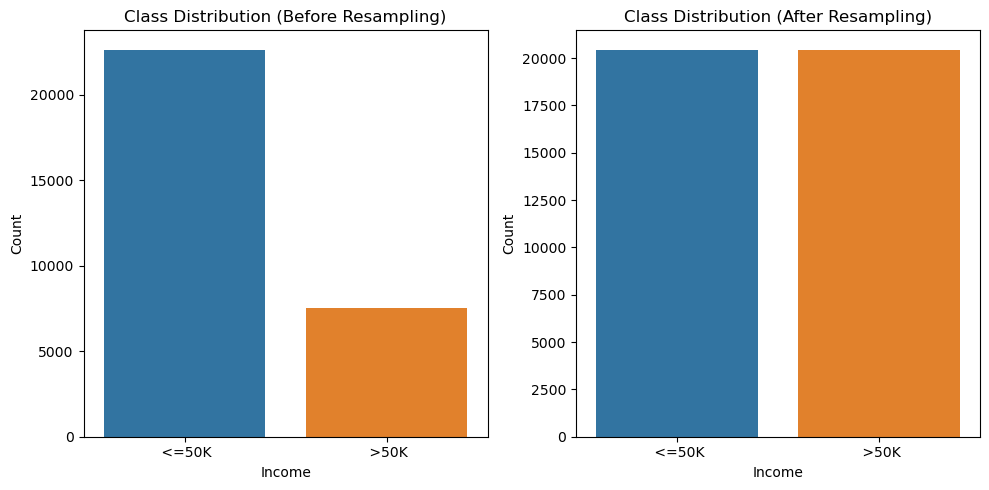

In [35]:
# Combine the resampled features and target variable to create a new dataset
new_data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis = 1)
print(X_res.shape)
print(new_data.income.value_counts())


# Count the class distribution in the original dataset
class_counts_before_resampling = data['income'].value_counts()

# Count the class distribution in the resampled dataset
class_counts_after_resampling = new_data['income'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 5))

# Plotting the bar graph for imbalanced data before resampling
plt.subplot(1, 2, 1)
sns.barplot(x=class_counts_before_resampling.index, y=class_counts_before_resampling.values)
plt.title('Class Distribution (Before Resampling)')
plt.xlabel('Income')
plt.ylabel('Count')

# Plotting the bar graph for balanced data after resampling
plt.subplot(1, 2, 2)
sns.barplot(x=class_counts_after_resampling.index, y=class_counts_after_resampling.values)
plt.title('Class Distribution (After Resampling)')
plt.xlabel('Income')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
new_data[numerical_features] = scaler.fit_transform(new_data[numerical_features])


In [44]:
# Remove outliers
z_scores = np.abs(stats.zscore(new_data[numerical_features]))
new_data = new_data[(z_scores < 3).all(axis=1)]

# Analyze relationships
# Example: Relationship between 'education' and 'income'
if 'education' in new_data.columns:
    education_income = new_data.groupby('education')['income'].value_counts(normalize=True).unstack()
    print(education_income)
else:
    print("Column 'education' not found in the dataset.")

income        <=50K      >50K
education                    
0          0.908046  0.091954
1          0.912184  0.087816
2          0.829060  0.170940
3               NaN  1.000000
4               NaN  1.000000
5          0.811359  0.188641
6          0.759414  0.240586
7          0.536269  0.463731
8          0.438919  0.561081
9          0.380358  0.619642
10         0.034556  0.965444
11         0.673203  0.326797
12         0.263378  0.736622
13              NaN  1.000000
14         0.089733  0.910267
15         0.772051  0.227949


                     age  workclass    fnlwgt  education  education_num  \
age             1.000000   0.034196 -0.075016   0.002933       0.078296   
workclass       0.034196   1.000000 -0.030153   0.006651      -0.000154   
fnlwgt         -0.075016  -0.030153  1.000000  -0.003917      -0.019523   
education       0.002933   0.006651 -0.003917   1.000000       0.248905   
education_num   0.078296  -0.000154 -0.019523   0.248905       1.000000   
marital_status -0.315730   0.009602  0.031316  -0.030549      -0.080400   
occupation     -0.009204   0.026676  0.008023  -0.030347       0.093104   
relationship   -0.276076  -0.015214  0.010095  -0.008634      -0.133439   
race            0.023339   0.034421 -0.017385   0.012978       0.023129   
sex             0.089793   0.047019  0.013349  -0.024867       0.013633   
capital_gain    0.105199  -0.030905  0.002268   0.002926       0.087343   
capital_loss    0.001030   0.001007  0.027402  -0.004140      -0.001988   
hours_per_week  0.144502 

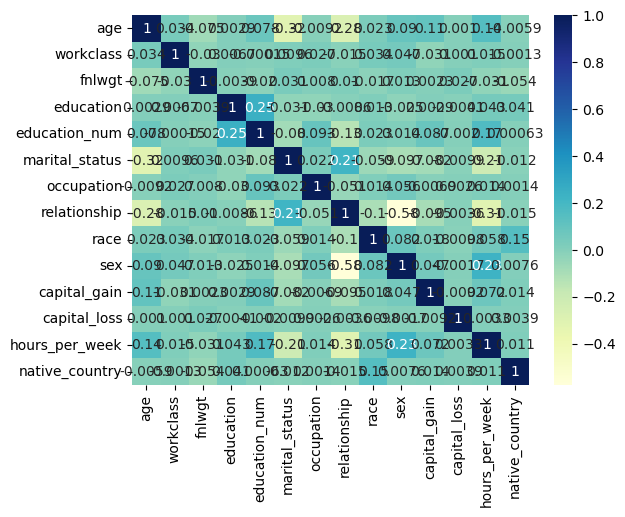

In [48]:
# Calculate correlations
correlation_matrix = new_data.corr()
print(correlation_matrix)

# Heatmap for correlation_matrix
dataplot = sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True)


In [49]:
# Feature Engineering
# Example: Creating a new feature 'income_level' based on 'income'
new_data['income_level'] = np.where(new_data['income'] == '>50K', 1, 0)

# Feature Selection (removal of collinear features)
# Example: Removing 'education_num' as it is highly correlated with 'education'
new_data = new_data.drop('income_level', axis=1)

# Split the data into training and testing sets
X = new_data.drop('income', axis=1)

#X_train = X_train.drop('income', axis=1)
#X_test = X_test.drop('income', axis=1)
y = new_data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [50]:
# Train and evaluate classification models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machines': SVC()
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    classification_report_str = classification_report(y_test, y_pred_test)
    confusion_matrix_str = confusion_matrix(y_test, y_pred_test)

    results[model_name] = {
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'classification_report': classification_report_str,
        'confusion_matrix': confusion_matrix_str
    }


C:\Users\Jignesh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Jignesh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

Model: Decision Tree
Train Accuracy: 0.9999633565408574
Test Accuracy: 0.849626264106698
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.86      0.86      3648
        >50K       0.84      0.84      0.84      3175

    accuracy                           0.85      6823
   macro avg       0.85      0.85      0.85      6823
weighted avg       0.85      0.85      0.85      6823

Confusion Matrix:
[[3122  526]
 [ 500 2675]]


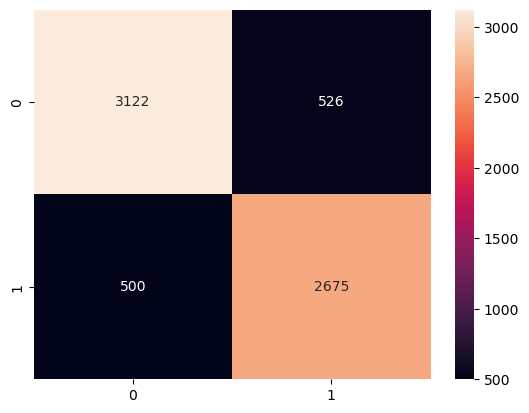


Model: Random Forest
Train Accuracy: 0.9999633565408574
Test Accuracy: 0.890663930822219
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.90      0.90      3648
        >50K       0.88      0.88      0.88      3175

    accuracy                           0.89      6823
   macro avg       0.89      0.89      0.89      6823
weighted avg       0.89      0.89      0.89      6823

Confusion Matrix:
[[3271  377]
 [ 369 2806]]


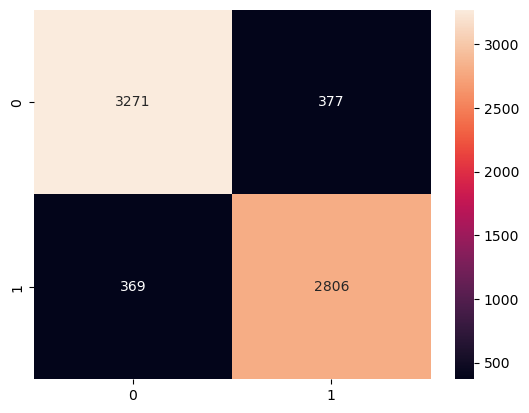


Model: K-Nearest Neighbors
Train Accuracy: 0.8912788567240747
Test Accuracy: 0.8396599736186429
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.84      0.86      0.85      3648
        >50K       0.83      0.82      0.83      3175

    accuracy                           0.84      6823
   macro avg       0.84      0.84      0.84      6823
weighted avg       0.84      0.84      0.84      6823

Confusion Matrix:
[[3128  520]
 [ 574 2601]]


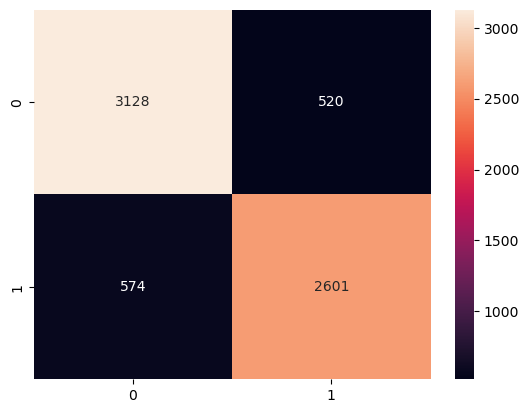


Model: Support Vector Machines
Train Accuracy: 0.7423598387687798
Test Accuracy: 0.7419023889784552
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.82      0.66      0.73      3648
        >50K       0.68      0.83      0.75      3175

    accuracy                           0.74      6823
   macro avg       0.75      0.75      0.74      6823
weighted avg       0.76      0.74      0.74      6823

Confusion Matrix:
[[2412 1236]
 [ 525 2650]]


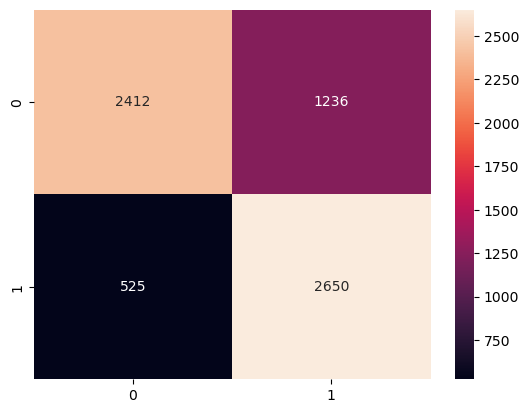

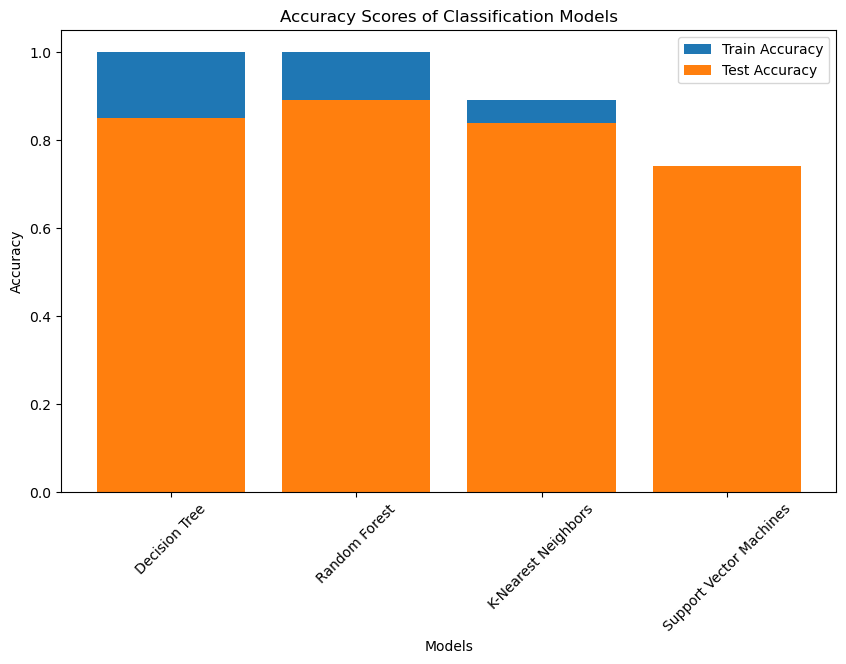

Results Table:
                        accuracy_train accuracy_test  \
Model                                                  
Decision Tree                 0.999963      0.849626   
Random Forest                 0.999963      0.890664   
K-Nearest Neighbors           0.891279       0.83966   
Support Vector Machines        0.74236      0.741902   

                                                     classification_report  \
Model                                                                        
Decision Tree                          precision    recall  f1-score   ...   
Random Forest                          precision    recall  f1-score   ...   
K-Nearest Neighbors                    precision    recall  f1-score   ...   
Support Vector Machines                precision    recall  f1-score   ...   

                                    confusion_matrix  
Model                                                 
Decision Tree             [[3122, 526], [500, 2675]]  
Random Forest 

In [51]:
# Print the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Train Accuracy: {result['accuracy_train']}")
    print(f"Test Accuracy: {result['accuracy_test']}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    sns.heatmap(result['confusion_matrix'], fmt='d', annot = True)
    plt.show()
    print()

# Generate plots and tables
accuracy_scores_train = [result['accuracy_train'] for result in results.values()]
accuracy_scores_test = [result['accuracy_test'] for result in results.values()]
models_list = list(results.keys())

# Plot the accuracy scores for train and test data
plt.figure(figsize=(10, 6))
plt.bar(models_list, accuracy_scores_train, label='Train Accuracy')
plt.bar(models_list, accuracy_scores_test, label='Test Accuracy')
plt.title('Accuracy Scores of Classification Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Create a table of results
results_df = pd.DataFrame(results).transpose()
results_df['Model'] = models_list
results_df.set_index('Model', inplace=True)


print("Results Table:")
print(results_df)